# 1.数据的读取

### 1.1引入之后分析所需要用到的所有库

In [1]:
# 加载数据分析需要使用的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.faker import Faker
import os
from pyecharts.charts import Pie
from pyecharts.charts import Map
from pyecharts.options import VisualMapOpts, TitleOpts, LegendOpts
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置无衬线字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决显示负号的问题
 
plt.rcParams['font.sans-serif'] = ['SimHei']
warnings.filterwarnings('ignore')

### 1.2读取数据，同时从发货日期和订货日期中得到年月，同时增加单价，发货用时，以及timecount方便后续计算次数

PS：增加折扣，衡量是否存在打折促销，当然，有个问题就是地区间的物价也会导致商品价格不一

In [2]:
data = pd.read_excel(r"D:\class math\data analysis\某超市某类产品订单数据.xlsx")
data['发货年'] = data['发货日期'].apply(lambda x:x.year)
data['发货月'] = data['发货日期'].apply(lambda x:x.month)
data['订货年'] = data['订单日期'].apply(lambda x:x.year)
data['订货月'] = data['订单日期'].apply(lambda x:x.month)
data['发货用时'] = data['发货日期'] - data['订单日期']
data['发货用时'] = data['发货用时'].apply(lambda x:x.days)
data['单价/元'] = data['销售额/元'] / data['数量/个']
data['月'] = data['订单日期'].values.astype('datetime64[M]')
data['timecount'] = 1
data['产品类别全名'] = data['产品类别'] + data['产品子类别']
data['discount'] = int(1)
data['if_discount'] = 0
origin_price = data[['产品 ID','单价/元']].groupby('产品 ID').max().reset_index()
for i in range(len(data.index)):
    if (data['单价/元'][i] != origin_price[origin_price['产品 ID'] == data['产品 ID'][i]]['单价/元'].values[0]):
        data['discount'][i] = ((data['单价/元'][i] / origin_price[origin_price['产品 ID'] == data['产品 ID'][i]]['单价/元'].values[0]).round(1))
        data['if_discount'][i] = int(1)
    else:
        continue

# 2.数据预处理

### 2.1复制数据，检查是否存在缺失值，没有缺失值和重复值，跳过补全

In [3]:
df = data.copy()
df.info()
df.duplicated().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9863 entries, 0 to 9862
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   订单 ID        9863 non-null   object        
 1   订单日期         9863 non-null   datetime64[ns]
 2   发货日期         9863 non-null   datetime64[ns]
 3   客户 ID        9863 non-null   int64         
 4   客户细分         9863 non-null   object        
 5   城市           9863 non-null   object        
 6   省/自治区        9863 non-null   object        
 7   地区           9863 non-null   object        
 8   产品 ID        9863 non-null   object        
 9   产品类别         9863 non-null   object        
 10  产品子类别        9863 non-null   object        
 11  产品名称         9863 non-null   object        
 12  销售额/元        9863 non-null   float64       
 13  数量/个         9863 non-null   int64         
 14  利润/元         9863 non-null   float64       
 15  发货年          9863 non-null   int64         
 16  发货月   

False

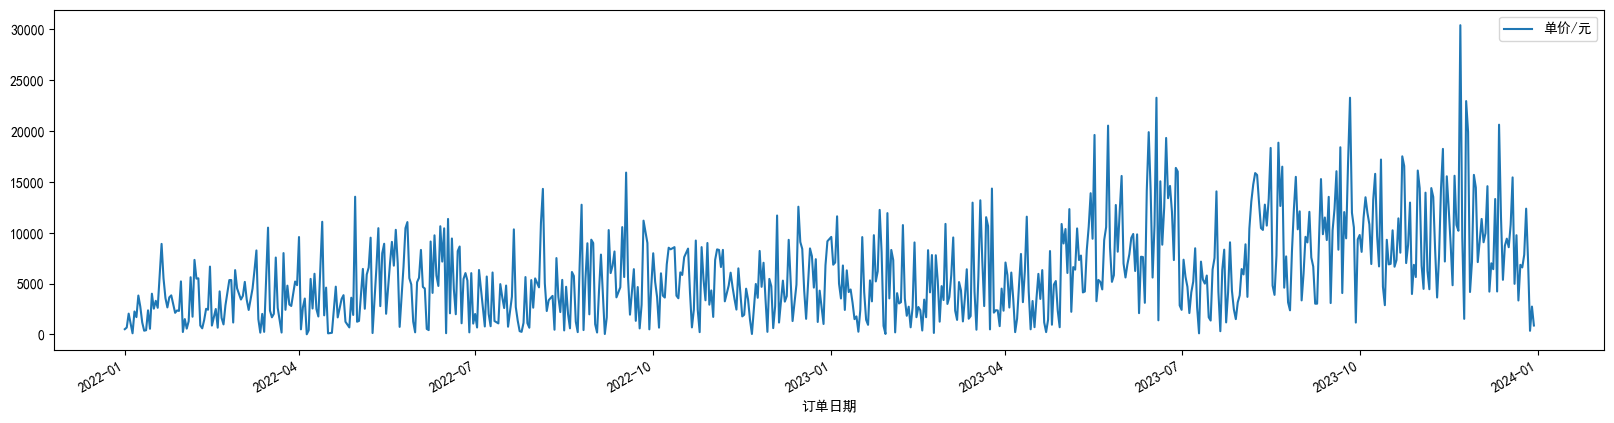

In [7]:
df['weekday'] = df['订单日期'].dt.weekday
df1 = df[['weekday','订单日期','单价/元']].groupby(by=['订单日期','weekday']).sum().reset_index()
df1.plot(x='订单日期',y='单价/元',figsize=(20,5))
plt.show()

<Axes: xlabel='单价/元', ylabel='Density'>

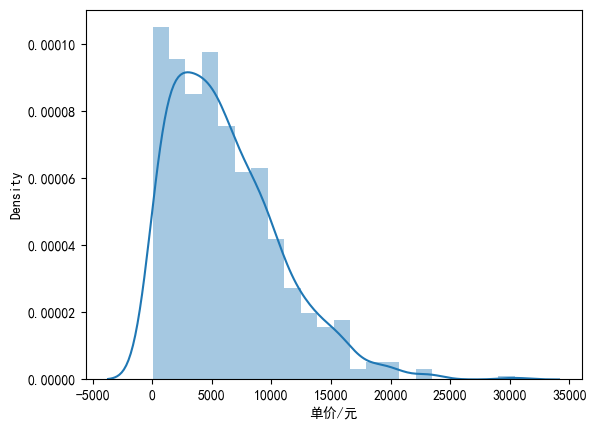

In [8]:
sns.distplot(df1['单价/元'])

In [ ]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

### 2.2 描述性统计数据，查看数据内是否存在异常值

In [5]:
# 使用describe得到数据的各项
df[['销售额/元'	,'数量/个','利润/元','发货用时',	'单价/元',	'timecount',	'discount']].describe()

,销售额/元,数量/个,利润/元,发货用时,单价/元,timecount,discount
count,9863.000000,9863.000000,9863.000000,9863.000000,9863.000000,9863.0,9863.000000
mean,1618.499903,3.768529,216.373430,3.949103,429.067116,1.0,0.899128
std,2650.592763,2.238981,861.885115,1.724789,559.010052,0.0,0.184815
min,13.440000,1.000000,-7978.320000,0.000000,9.380000,1.0,0.100000
25%,251.062000,2.000000,7.840000,3.000000,79.296000,1.0,0.900000
50%,636.300000,3.000000,74.760000,4.000000,213.360000,1.0,1.000000
75%,1786.890000,5.000000,278.740000,5.000000,572.180000,1.0,1.000000
max,35621.355000,14.000000,10108.280000,8.000000,3238.305000,1.0,1.000000


# 3.数据预分析

### 3.1进行单因素分析

In [6]:
numerical = df.select_dtypes(include = 'number').columns
categorical = df.select_dtypes(include = 'object').columns
categorical

Index(['订单 ID', '客户细分', '城市', '省/自治区', '地区', '产品 ID', '产品类别', '产品子类别', '产品名称',
       '产品类别全名'],
      dtype='object')

In [7]:
categorical = df.select_dtypes(include = 'object').columns.delete([0,2,3,5,8,7,6]) #收据单号可视化暂无意义删去
numerical = df.select_dtypes(include = 'number').columns.delete([0,4,5,6,7,8])
categorical,numerical

(Index(['客户细分', '地区', '产品类别全名'], dtype='object'),
 Index(['销售额/元', '数量/个', '利润/元', '单价/元', 'timecount', 'discount',
        'if_discount'],
       dtype='object'))

3.1.1得到不同类型的客户的占比，不同地区客户的占比，产品销售次数的比例

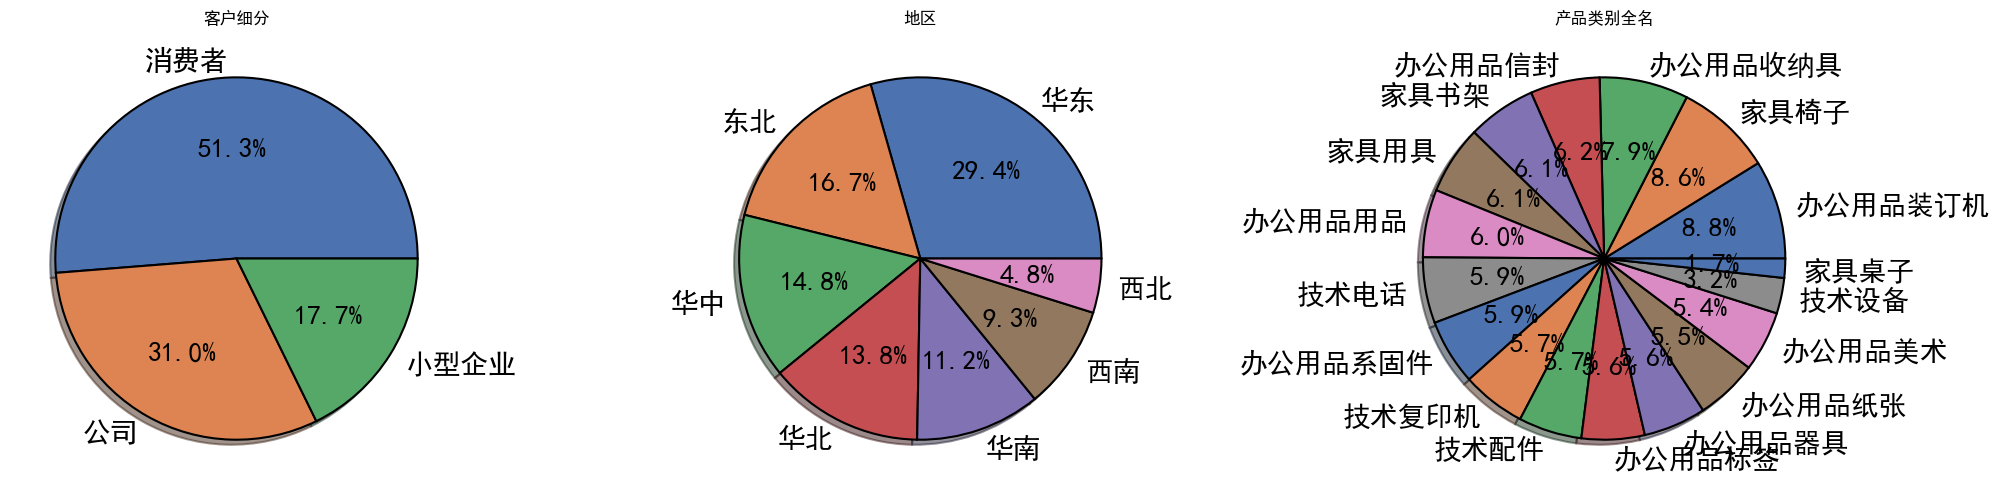

In [8]:
# 单因素分析
fig, ax = plt.subplots(3, 3, figsize=(25, 20))
palette = sns.color_palette('deep', 8)
for axi, col in zip(ax.flatten(), categorical):
    pie_data = df[col].value_counts()
    axi.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%',
            shadow=True, wedgeprops={'edgecolor': 'black', 'lw': 1.5}, colors=palette)
    
    for autotext in axi.texts:
        autotext.set_color('black')
        autotext.set_weight('bold')
        autotext.set_size(20)
    
    axi.set_title(col, fontweight='bold')

for axi in ax.flatten()[len(categorical):]:
    axi.remove()
plt.show()

# 4.从时间维度进行分析

### 4.1得到每年各月的销售数据

In [9]:
sale_year = df[['timecount','销售额/元', '数量/个', '利润/元', '订货年','订货月','发货用时','单价/元']].groupby(['订货年','订货月'])
sale_year_sum = sale_year.sum()
sale_year_sum['单价/元'] = sale_year_sum['单价/元'] / sale_year_sum['timecount']
sale_year_sum['发货用时'] = sale_year_sum['发货用时'] / sale_year_sum['timecount']
year_2022 = sale_year_sum.loc[(2022,slice(None)),:].reset_index()
year_2023 = sale_year_sum.loc[(2023,slice(None)),:].reset_index()
sales=pd.concat([year_2022[['timecount','销售额/元', '数量/个', '利润/元','发货用时','单价/元']],year_2023[['timecount','销售额/元', '数量/个', '利润/元','发货用时','单价/元']]],axis=1)
 
# 对行名和列名进行重命名
sales.columns=['2022各月达成交易单数','2022各月销售额','2022各月出售的总商品数','2022各月利润','2022各月发货平均用时','2022平均销售单价','2023各月达成交易单数','2023各月销售额','2023各月出售的总商品数','2023各月利润','2023各月发货平均用时','2023平均销售单价']
sales.index=['Jau','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# 颜色越深，销售额越高
sales.style.background_gradient()
# sales.to_excel('年销售数据.xlsx')

,2022各月达成交易单数,2022各月销售额,2022各月出售的总商品数,2022各月利润,2022各月发货平均用时,2022平均销售单价,2023各月达成交易单数,2023各月销售额,2023各月出售的总商品数,2023各月利润,2023各月发货平均用时,2023平均销售单价
Jau,159,222862.829000,605,33526.269000,3.955975,450.585994,362,583124.374000,1344,97551.594000,3.861878,440.221414
Feb,184,285475.428000,692,34466.908000,3.967391,435.278489,265,412907.432000,1010,46522.392000,4.030189,424.399249
Mar,225,399711.781000,899,56542.521000,4.128889,440.710822,351,569855.104000,1296,84829.164000,3.846154,452.954165
Apr,194,333268.621000,776,32764.781000,3.809278,450.844598,319,444887.821000,1164,83889.281000,4.137931,391.010959
May,377,632800.350000,1466,68430.670000,4.002653,406.819056,651,1059657.144000,2370,148103.704000,4.152074,422.685613
Jun,370,565523.427000,1388,81670.267000,3.705405,438.870865,694,1125909.071000,2555,128052.491000,3.976945,447.733203
Jul,174,340308.682000,688,58861.922000,3.816092,452.896782,352,542913.203000,1268,63576.303000,4.144886,414.641878
Aug,343,588746.354000,1325,55773.074000,3.790087,422.541184,690,1224484.702000,2639,209937.322000,3.721739,469.638014
Sep,311,502799.255000,1216,80341.275000,4.122186,435.548868,680,1099880.579000,2536,124972.239000,3.772059,435.924022
Oct,348,577450.321000,1262,72686.621000,3.945402,435.074138,756,1129170.294000,2822,129296.594000,3.937831,403.337333


### 4.2两年的消费次数，销售额，商品数量，利润的增长率

In [10]:
# 两年的消费次数，销售额，商品数量，利润
sales_sum = sales.sum()
rise = []
for i in range(int(len(sales_sum.index)/2)):
    rise.append(sales_sum[i+int(len(sales_sum.index)/2)] / sales_sum[i] - 1)
rise

[0.9215047393364928,
 0.9224391084491348,
 0.8793090092183748,
 1.1329551592217477,
 0.0013572136256658762,
 0.005985685536836982]

### 4.3分年得到每月的利润率, 单月销售额月/年增长率,	单月利润率月/年增长率, 单月销售数量月/年增长率,	单月利润月/年增长率,	单月送货用时月/年增长率

In [11]:
# 每月的利润率，销售增长率，利润增长率，数量增长率，发货时间增长率
Earnings_statement = df[['订货月','订货年','发货用时','timecount','销售额/元','数量/个','利润/元']].groupby(['订货年','订货月']).sum()
Earnings_statement['发货用时'] = Earnings_statement['发货用时'] / Earnings_statement['timecount']
Earnings_statement['profit_rate'] = round(Earnings_statement['利润/元'] / Earnings_statement['销售额/元'],4)
Earnings_statement['Sales_growth_rate'] = (Earnings_statement['销售额/元']-Earnings_statement['销售额/元'].shift())/Earnings_statement['销售额/元'].shift()
Earnings_statement['Profit_growth_rate'] = (Earnings_statement['利润/元']-Earnings_statement['利润/元'].shift())/Earnings_statement['利润/元'].shift()
Earnings_statement['Quantity_growth_rate'] = (Earnings_statement['数量/个']-Earnings_statement['数量/个'].shift())/Earnings_statement['数量/个'].shift()
Earnings_statement['profit_rate_growth_rate'] = (Earnings_statement['profit_rate']-Earnings_statement['profit_rate'].shift())/Earnings_statement['profit_rate'].shift()
Earnings_statement['Shipping_Cost_growth_rate'] = (Earnings_statement['发货用时']-Earnings_statement['发货用时'].shift())/Earnings_statement['发货用时'].shift()
Earnings_statement['Sales_year_growth_rate'] = (Earnings_statement['销售额/元']-Earnings_statement['销售额/元'].shift(12))/Earnings_statement['销售额/元'].shift(12)
Earnings_statement['Profit_year_growth_rate'] = (Earnings_statement['利润/元']-Earnings_statement['利润/元'].shift(12))/Earnings_statement['利润/元'].shift(12)
Earnings_statement['Quantity_year_growth_rate'] = (Earnings_statement['数量/个']-Earnings_statement['数量/个'].shift(12))/Earnings_statement['数量/个'].shift(12)
Earnings_statement['profit_rate_year_growth_rate'] = (Earnings_statement['profit_rate']-Earnings_statement['profit_rate'].shift(12))/Earnings_statement['profit_rate'].shift(12)
Earnings_statement['Shipping_Costyear__growth_rate'] = (Earnings_statement['发货用时']-Earnings_statement['发货用时'].shift(12))/Earnings_statement['发货用时'].shift(12)
Earnings_statement = Earnings_statement.fillna(0)
print(Earnings_statement.columns)
Earnings_statement.columns = ['发货用时','timecount','销售额/元','数量/个','利润/元','利润率',	'单月销售额月增长率',	'单月利润月增长率',	'单月销售数量月增长率',	'单月利润率月增长率',	'单月送货用时月增长率',	'单月销售额年增长率',	'单月利润年增长率',	'单月销售商品数量年增长率',	'单月利润率年增长率'	,'单月送货用时年增长率']
Earnings_statement[['利润率','单月销售额月增长率',	'单月利润率月增长率',	'单月销售数量月增长率',	'单月利润月增长率',	'单月送货用时月增长率',	'单月销售额年增长率',	'单月利润年增长率',	'单月销售商品数量年增长率',	'单月利润率年增长率'	,'单月送货用时年增长率']].round(4).style.background_gradient()
# Earnings_statement.to_excel('月销售增长.xlsx')

Index(['发货用时', 'timecount', '销售额/元', '数量/个', '利润/元', 'profit_rate',
       'Sales_growth_rate', 'Profit_growth_rate', 'Quantity_growth_rate',
       'profit_rate_growth_rate', 'Shipping_Cost_growth_rate',
       'Sales_year_growth_rate', 'Profit_year_growth_rate',
       'Quantity_year_growth_rate', 'profit_rate_year_growth_rate',
       'Shipping_Costyear__growth_rate'],
      dtype='object')


In [12]:
df.columns

Index(['订单 ID', '订单日期', '发货日期', '客户 ID', '客户细分', '城市', '省/自治区', '地区', '产品 ID',
       '产品类别', '产品子类别', '产品名称', '销售额/元', '数量/个', '利润/元', '发货年', '发货月', '订货年',
       '订货月', '发货用时', '单价/元', '月', 'timecount', '产品类别全名', 'discount',
       'if_discount'],
      dtype='object')

### 4.4 得到两年各月的客户变化情况

<Axes: >

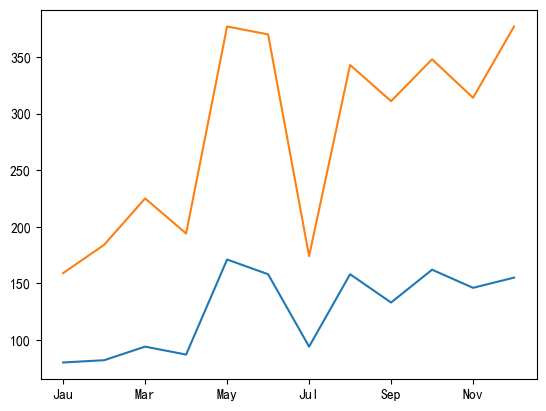

In [13]:
# 得到各月份交易达成单数
df2 = df.copy()
df2.drop_duplicates(subset=['订货年','订货月','客户 ID'],inplace=True)
customer = df2[['订货年','订货月','timecount']].groupby(['订货年','订货月']).sum().reset_index()
# 得到各月的客户数量的线条，蓝色的
customer[customer['订货年'] == 2022]['timecount'].plot()
# 得到各月的交易单数线条，橙色的
sales['2022各月达成交易单数'].plot()

<Axes: >

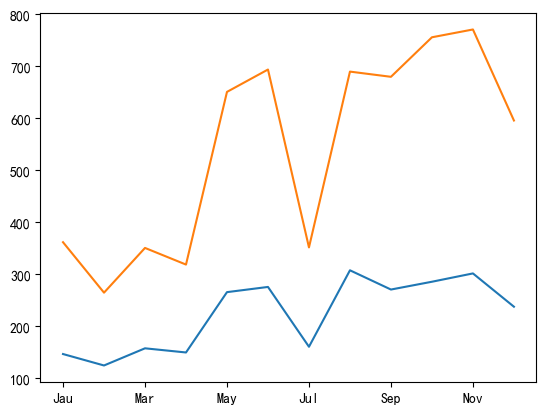

In [14]:
# 得到各月的客户数量的线条，蓝色的
c2023 = customer[12:].reset_index()
c2023[c2023['订货年'] == 2023]['timecount'].plot(x=range(12))
# 得到各月的交易单数线条，橙色的
sales['2023各月达成交易单数'].plot()

### 4.5得到月份与折扣率关系

In [15]:
# 每个月的打折力度,下半年打折力度强，可以考虑上半年的打折活动
month_dicount = pd.pivot_table(df,index=['订货月'],columns=['discount'],aggfunc={'discount':'count'} )
month_dicount = month_dicount
month_dicount = month_dicount.fillna(0)
month_dicount.style.background_gradient()
# month_dicount.to_excel('月份折扣力度表.xlsx')

# 5.从空间（地区）维度进行分析

### 5.1分地区得到每个地区两年的销售额，发现从销售额角度来看，每个地区都在增长

Text(0.5, 1.0, '2011-2014 market sales')

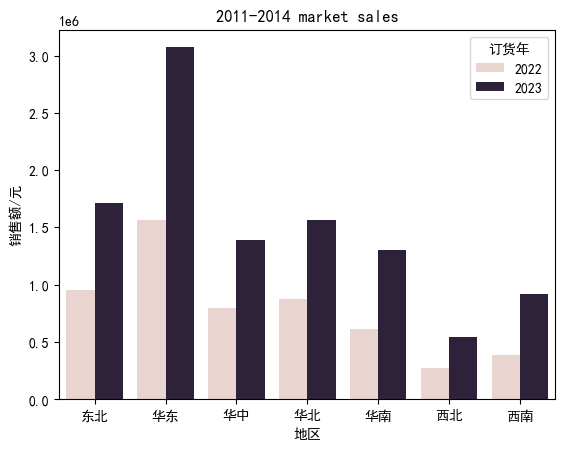

In [16]:
Market_Year_Sales = df[['地区','订货年', '销售额/元', '数量/个', '利润/元','发货用时', 'timecount']].groupby(['地区','订货年'])
Market_Year_Sales_sum = Market_Year_Sales.sum().reset_index()
Market_Year_Sales_sum['发货用时'] = Market_Year_Sales_sum['发货用时'] / Market_Year_Sales_sum['timecount']
Market_Year_Sales_sum['单价'] = Market_Year_Sales_sum['销售额/元'] / Market_Year_Sales_sum['timecount']
sns.barplot(x='地区', y= '销售额/元', hue='订货年', data = Market_Year_Sales_sum[['地区','订货年', '销售额/元']])
plt.title('2011-2014 market sales')

### 5.2每个地区的利润与销售额占比，同时得到华东，华中，华北，东北四个地区的销售额和利润占比就已经接近百分之八十

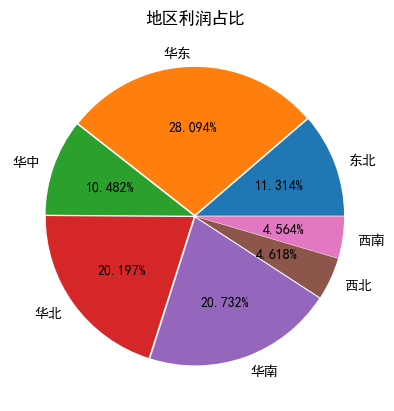

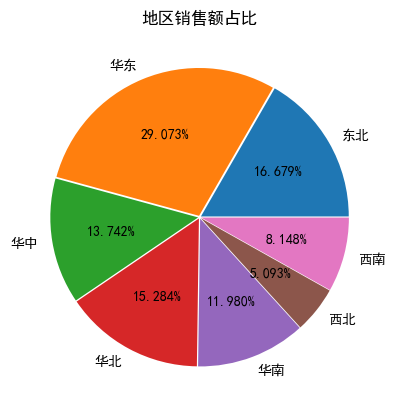

,销售额/元,数量/个,利润/元,发货用时,timecount,销售占比,利润占比
地区,,,,,,,
东北,2662587.865000,6386,241444.525000,6664,1647,0.166795,0.113137
华东,4641016.702000,10885,599547.942000,11239,2902,0.457526,0.394075
华中,2193676.240000,5530,223695.920000,5831,1456,0.594946,0.498895
华北,2439791.697000,5131,431019.057000,5605,1365,0.747784,0.700864
华南,1912453.025000,4073,442438.045000,4179,1101,0.867587,0.908183
西北,813030.316000,1779,98553.476000,1855,477,0.918519,0.954364
西南,1300708.696000,3385,97392.176000,3577,915,1.000000,1.000000


In [17]:
Market_Sale = df[['地区', '销售额/元', '数量/个', '利润/元','发货用时', 'timecount']].groupby(['地区']).sum()
Market_Sale["销售占比"] = Market_Sale['销售额/元'].cumsum() / df['销售额/元'].sum()
Market_Sale["利润占比"] = Market_Sale['利润/元'].cumsum() / df['利润/元'].sum()
area = Market_Sale['销售额/元'].index
plt.pie(Market_Sale['利润/元'],explode=[0.01]*7,labels=area,autopct="%1.3f%%")
plt.title('地区利润占比')
plt.show()
plt.pie(Market_Sale['销售额/元'],explode=[0.01]*7,labels=area,autopct="%1.3f%%")
plt.title('地区销售额占比')
plt.show()
Market_Sale.style.background_gradient()

### 5.3做全国省份利润热力图

修改名称，方便后续作全国热力图

In [4]:
df = data.copy()
 
# 基础数据
df['省/自治区'] = data['省/自治区']
print(df['省/自治区'].value_counts().index)
# 省和直辖市,在做热力图前需要把名称修改为全称
for i in range(len(df['省/自治区'])):
    if df['省/自治区'][i] in ['北京','天津','重庆','上海']:
        df['省/自治区'][i] += '市'
    elif df['省/自治区'][i] in ['中国香港特别行政区','中国澳门特别行政区']:
        df['省/自治区'][i] = df['省/自治区'][i][2:]
    elif df['省/自治区'][i] == '新疆':
        df['省/自治区'][i] += '维吾尔自治区'
    elif df['省/自治区'][i] == '广西':
        df['省/自治区'][i] += '壮族自治区'
    elif df['省/自治区'][i] == '宁夏':
        df['省/自治区'][i] += '回族自治区'
    elif df['省/自治区'][i] == '内蒙古':
        df['省/自治区'][i] += '自治区'
    elif df['省/自治区'][i] == '西藏':
        df['省/自治区'][i] += '自治区'
    else:
        df['省/自治区'][i] += '省'


Index(['山东', '广东', '辽宁', '黑龙江', '江苏', '湖北', '河南', '湖南', '浙江', '四川', '河北', '吉林',
       '安徽', '天津', '上海', '福建', '北京', '陕西', '重庆', '内蒙古', '广西', '山西', '云南', '甘肃',
       '江西', '海南', '贵州', '宁夏', '新疆', '青海', '西藏', '中国香港特别行政区', '中国澳门特别行政区',
       '台湾'],
      dtype='object', name='省/自治区')


In [5]:
df.to_excel('supermarket.xlsx')

得到全国利润热力图

In [19]:
province_distribution = df[['省/自治区', '销售额/元', '数量/个', '利润/元','发货用时', 'timecount']].groupby(['省/自治区']).sum().reset_index()
lens = province_distribution['利润/元'].max() - province_distribution['利润/元'].min()
maxs = province_distribution['利润/元'].max()
provice = province_distribution['省/自治区'].tolist()
values = province_distribution['利润/元'].tolist()
sequences = list(zip(provice,values))
print(sequences)
def map_visualmap(sequence, year) -> Map:
    c = (
        Map(opts.InitOpts(width='1200px',height='600px'))               #  opts.InitOpts() 设置初始参数:width=画布宽,height=画布高
            .add(series_name=year, data_pair=sequence, maptype="china" )       # 系列名称(显示在中间的名称 )、数据 、地图类型
            .set_global_opts(
            title_opts=opts.TitleOpts(title="地图"),
            visualmap_opts=opts.VisualMapOpts(max_=province_distribution['利润/元'].max(), min_=province_distribution['利润/元'].min()),
        )
    )
    return c
maps = map_visualmap(sequence=sequences,year='province')
maps.render(path='./test.html')

[('上海市', 121483.348), ('云南省', 86639.168), ('内蒙古自治区', -57099.168), ('北京市', 91566.58), ('台湾省', 40.32), ('吉林省', 151629.751), ('四川省', -89255.796), ('天津市', 117704.09), ('宁夏回族自治区', 8537.619999999999), ('安徽省', 145445.23), ('山东省', 381108.728), ('山西省', 106885.59), ('广东省', 333540.585), ('广西壮族自治区', 84676.389), ('新疆维吾尔自治区', 14606.06), ('江苏省', -107547.72), ('江西省', 47807.06), ('河北省', 171961.965), ('河南省', 199644.991), ('浙江省', -130929.12), ('海南省', 39610.403), ('湖北省', -132056.932), ('湖南省', 156107.861), ('澳门特别行政区', 301.98), ('甘肃省', -42682.192), ('福建省', 142180.416), ('西藏自治区', 1266.5800000000002), ('贵州省', 18998.42), ('辽宁省', -167064.688), ('重庆市', 63955.471999999994), ('陕西省', 105814.688), ('青海省', 12277.3), ('香港特别行政区', 56.7), ('黑龙江省', 256879.462)]


'd:\\class math\\data analysis\\test.html'

### 5.4查询每个地区出售数量最多的商品

In [20]:
# 查询每个地区出售数量最多的商品
productId_amount = df[['地区', '数量/个','产品名称']].groupby(['地区','产品名称']).sum()
area_db = productId_amount.loc[('东北',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_hz = productId_amount.loc[('华中',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_hd = productId_amount.loc[('华东',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_hb = productId_amount.loc[('华北',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_hn = productId_amount.loc[('华南',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_xb = productId_amount.loc[('西北',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_xn = productId_amount.loc[('西南',slice(None)),:].reset_index().sort_values(by='数量/个',ascending=False)
area_lists = [area_db,area_hz,area_hb,area_hd,area_hn,area_xb,area_xn]

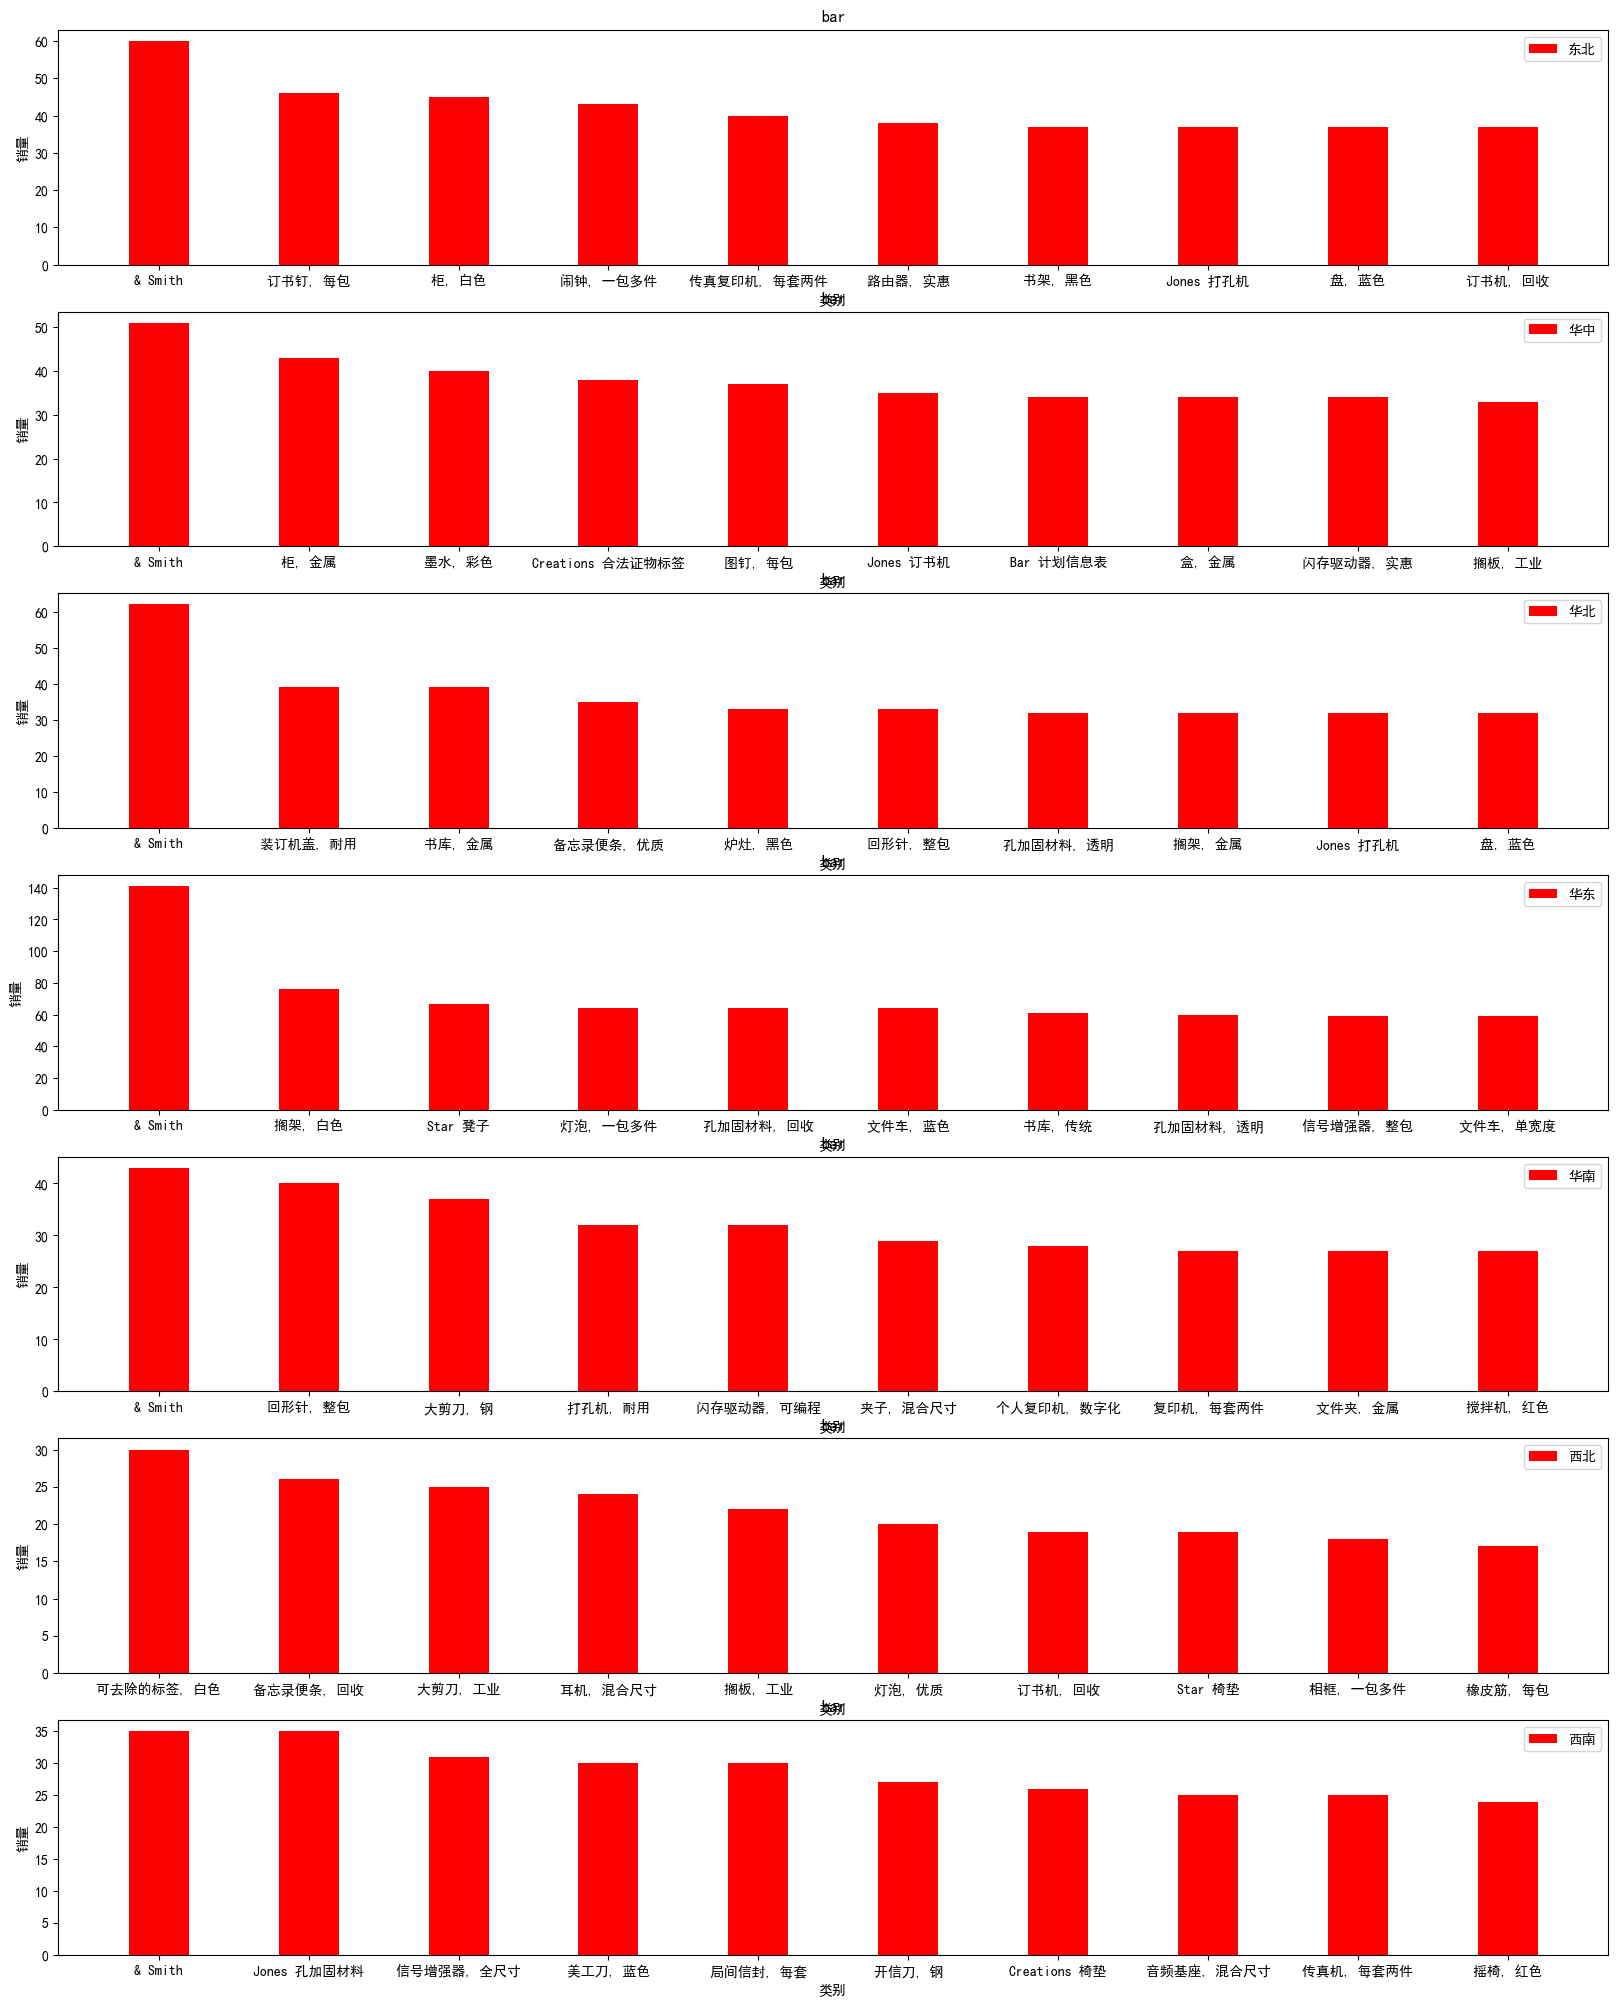

In [21]:
plt.figure(figsize=(20,25),dpi=100)
for axi in range(7):
    plt.subplot(7,1,axi+1)
    plt.bar(area_lists[axi].head(10)['产品名称'],area_lists[axi].head(10)['数量/个'],width=0.4, alpha=1, color='red', label=area_lists[axi]['地区'][0])
    plt.legend()
    plt.title("bar")
    plt.xlabel("类别")# 显示横轴标签
    plt.ylabel("销量")# 显示纵轴标签
plt.show()


### 5.5得到客户数量与销售额top10的城市

In [22]:
# 对城市进行评分，通过熵权法得到各指标占比
cities = df[['销售额/元', '数量/个', '利润/元','timecount','发货用时', '单价/元','城市']].groupby('城市').sum()
cities['发货用时'] = cities['发货用时'] / cities['timecount']
cities['单价/元'] = cities['单价/元'] / cities['timecount']
for i in list(cities.columns):
    Max = np.max(cities[i])
    Min = np.min(cities[i])
    if (i == 'Recency'):
        cities[i] = (Max - cities[i])/(Max - Min)
    else:
        cities[i] = (cities[i] - Min)/(Max - Min)
def bizhong(df_bizhong):
    for column in df_bizhong.columns:
        sigma = sum(df_bizhong[column])
        df_bizhong[column] = df_bizhong[column].apply(lambda x: x/sigma if x/sigma != 0 else 10**-6)
    return df_bizhong
df_bizhong = bizhong(cities)

k = 1 / np.log(575)
h_j = (-k) * np.array([sum([pij*np.log(pij) for pij in df_bizhong[column]]) for column in df_bizhong.columns])
h_js = pd.Series(h_j,index=df_bizhong.columns,name='指标的熵值')
df_bianyi = pd.Series(1-h_j,index=df_bizhong.columns,name='差异系数')
quanzhong = df_bianyi.to_dict()
for i in cities.columns:
  cities[i] += cities[i].apply(lambda x:x * quanzhong[i])
cities['level'] = cities['timecount'] + cities['利润/元'] + cities['单价/元'] + cities['发货用时'] + cities['数量/个'] + cities['销售额/元']
# 如此我们得到综合评分前十的城市
cities.sort_values('level',ascending=False).head(10).index.array

<NumpyExtensionArray>
['上海', '天津', '北京', '重庆', '武汉', '沈阳', '广州', '深圳', '西安', '洛阳']
Length: 10, dtype: object

### 5.6查看各省市利润分布

5.6.1从利润的角度分析各省份的价值，得到TOP5的省份与倒数的五个省份

<Axes: xlabel='省/自治区'>

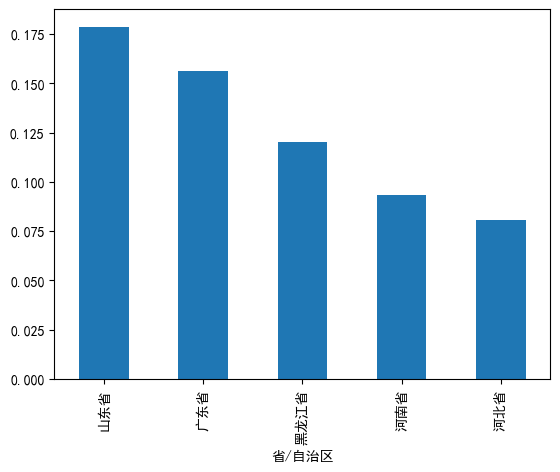

In [23]:
province_distribution = df[['省/自治区', '销售额/元', '数量/个', '利润/元','发货用时', 'timecount']].groupby(['省/自治区']).sum().reset_index()
province_distribution = province_distribution.set_index('省/自治区')
province_distribution = province_distribution.sort_values(by='利润/元',ascending=False)
province_distribution['利润/元'] = province_distribution['利润/元'] / province_distribution['利润/元'].sum()
province_distribution['利润/元'].head(5).plot(kind='bar')

<Axes: xlabel='省/自治区'>

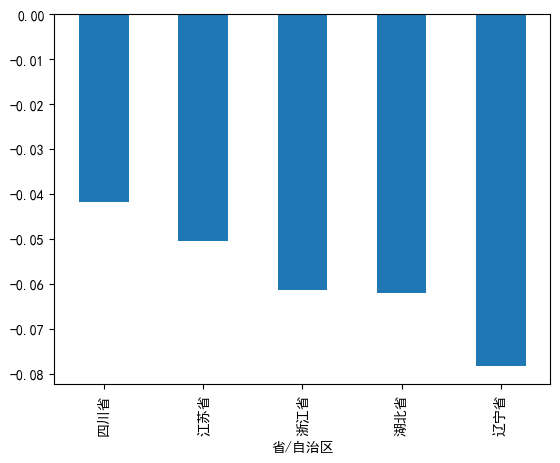

In [24]:
province_distribution['利润/元'].tail(5).plot(kind='bar')

5.6.2制作利润TOP5的省份各个城市利润占比的玫瑰图

In [25]:
# 读入数据，需要更改
dfr = df[['利润/元','城市','timecount','省/自治区']].groupby(['省/自治区','城市']).sum().reset_index().sort_values(by='利润/元',ascending=False) 
def rose_draw(province,dfr):
    v = dfr[dfr['省/自治区'] == province]['城市'].values.tolist()
    d = dfr[dfr['省/自治区'] == province]['利润/元'].values.tolist()
    # 设置颜色
    color_series = ['#FAE927', '#E9E416', '#C9DA36', '#9ECB3C', '#6DBC49',
                    '#37B44E', '#3DBA78', '#14ADCF', '#209AC9', '#1E91CA',
                    '#2C6BA0', '#2B55A1', '#2D3D8E', '#44388E', '#6A368B'
                    '#7D3990', '#A63F98', '#C31C88', '#D52178', '#D5225B',
                    '#D02C2A', '#D44C2D', '#F57A34', '#FA8F2F', '#D99D21',
                    '#CF7B25', '#CF7B25', '#CF7B25']
    # 实例化Pie类
    pie1 = Pie(init_opts=opts.InitOpts(width='1350px', height='750px'))
    # 设置颜色
    pie1.set_colors(color_series[:len(v)])
    # 添加数据，设置饼图的半径，是否展示成南丁格尔图
    pie1.add("222", [list(z) for z in zip(v, d)],
            radius=["15%", "100%"],
            center=["50%", "60%"],
            rosetype="area"
            )
    # 设置全局配置项
    pie1.set_global_opts(title_opts=opts.TitleOpts(title='玫瑰图示例'),
                        legend_opts=opts.LegendOpts(is_show=False),
                        toolbox_opts=opts.ToolboxOpts())
    # 设置系列配置项
    pie1.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=12,
                                                  formatter="{b}:{c}元", font_style="italic",
                                                  font_weight="bold", font_family="Microsoft YaHei"
                                                  ),
                        )
    # 生成html文档
    pie1.render(province+"利润分布图.html")

In [26]:
rose_draw('广东省',dfr)
rose_draw('黑龙江省',dfr)
rose_draw('河南省',dfr)
rose_draw('河北省',dfr)

### 5.7分析省份利润率和折扣的关系

确定利润率与的省份的折扣率关系，得到利润率高的折扣率低，低利润的省份折扣率高，当然也可能是因为利润低的省份物价也低，导致商品在那里价格低于其最高价，要进一步确认是否为打折，如果是那么就再进一步确认打折力度是否合理，是否为收支平衡点

In [27]:
# 确定利润率与的省份的折扣率关系，得到利润率高的折扣率低，低利润的省份折扣率高
province_profit = df[['省/自治区', '销售额/元', '数量/个', '利润/元','发货用时', 'timecount','if_discount']].groupby(['省/自治区']).sum().sort_values(by='利润/元',ascending=False)
province_profit['discount_precent'] = province_profit['if_discount'] / province_profit['timecount']
province_profit.head(5)['discount_precent'],province_profit.tail(5)['discount_precent']

(省/自治区
 山东省     0.186740
 广东省     0.308446
 黑龙江省    0.232227
 河南省     0.290466
 河北省     0.167959
 Name: discount_precent, dtype: float64,
 省/自治区
 四川省    0.775194
 江苏省    0.770435
 浙江省    0.798005
 湖北省    0.758261
 辽宁省    0.778603
 Name: discount_precent, dtype: float64)

# 6.从产品角度分析

### 6.1从销售量,利润,数量的角度得到最热门商品TOP10

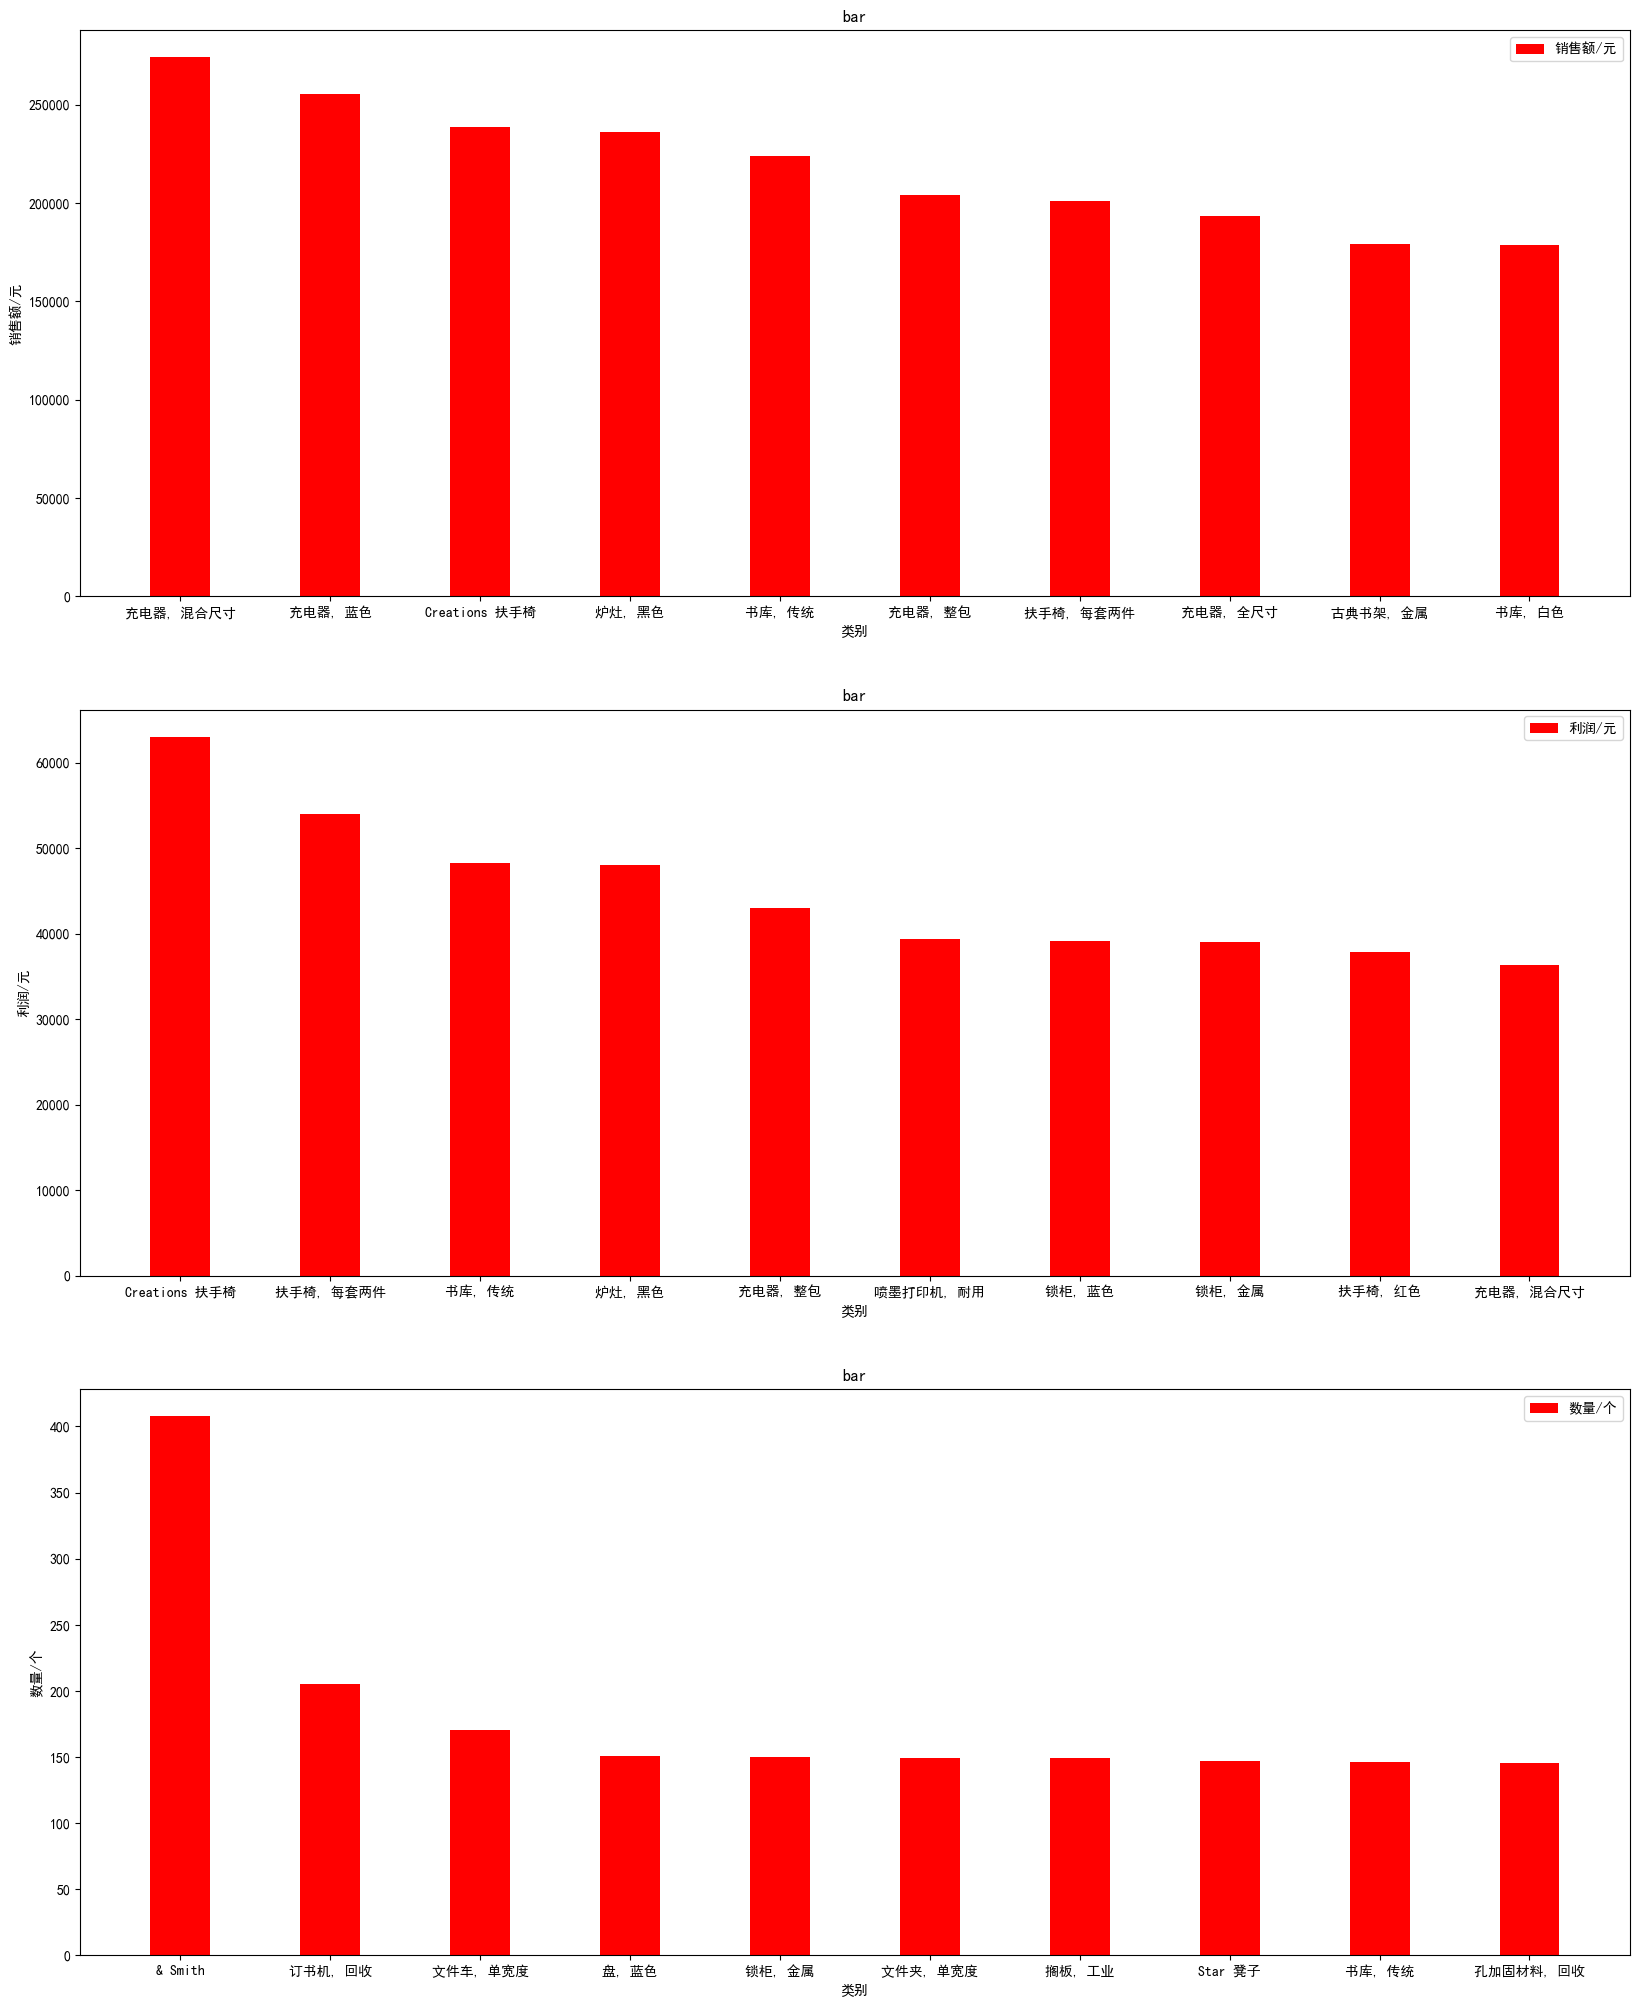

In [28]:
productId_xiao_amount = df[['销售额/元','产品名称','数量/个', '利润/元']].groupby(['产品名称']).sum().sort_values(by='销售额/元',ascending=False).reset_index()
productId_li_amount = productId_xiao_amount.sort_values(by='利润/元',ascending=False)
productId_num_amount = productId_xiao_amount.sort_values(by='数量/个',ascending=False)
productId_list = [productId_xiao_amount,productId_li_amount,productId_num_amount]
name_list = ['销售额/元','利润/元','数量/个']
plt.figure(figsize=(20,25),dpi=100)
for axi in range(3):
    plt.subplot(3,1,axi+1)
    plt.bar(productId_list[axi].head(10)['产品名称'],productId_list[axi].head(10)[name_list[axi]],width=0.4, alpha=1, color='red', label=name_list[axi])
    plt.legend()
    plt.title("bar")
    plt.xlabel("类别")# 显示横轴标签
    plt.ylabel(name_list[axi])# 显示纵轴标签
plt.show()

### 6.2按销售额，销售数量，利润得到产品类别排行

6.2.1得到可视化表格

In [29]:
# 按照新的种类进行分组，统计销售额和利润
df_Category_Sub_Category=df[['销售额/元', '数量/个', '利润/元','产品类别全名']].groupby('产品类别全名').sum().reset_index()
# 按照销售额倒序排序
df_Category_Sub_Category.sort_values(by=['销售额/元'],ascending=False, inplace=True)
# 每个种类商品的销售额累计占比
df_Category_Sub_Category['cum_percent'] = df_Category_Sub_Category['销售额/元'].cumsum()/df_Category_Sub_Category['销售额/元'].sum()
df_Category_Sub_Category.style.background_gradient()
# df_Category_Sub_Category.to_excel('各类别产品销售状况.xlsx')

,产品类别全名,销售额/元,数量/个,利润/元,cum_percent
9,家具书架,2297082.060000,2384,360645.600000,0.143898
1,办公用品器具,2140368.524000,2098,195402.284000,0.277979
11,家具椅子,2070354.104000,3140,321487.824000,0.407674
13,技术复印机,1981222.992000,2123,252333.732000,0.531785
14,技术电话,1794394.224000,2163,223888.644000,0.644193
2,办公用品收纳具,1137946.040000,2878,314397.860000,0.715478
15,技术设备,867215.524000,1228,143013.304000,0.769804
10,家具桌子,857067.113000,616,-133732.767000,0.823494
16,技术配件,802845.904000,2081,130811.184000,0.873787
12,家具用具,478058.756000,2287,85483.076000,0.903735


6.2.2各个种类产品的利润，数量，销售额递减柱状图

<Axes: xlabel='产品类别全名'>

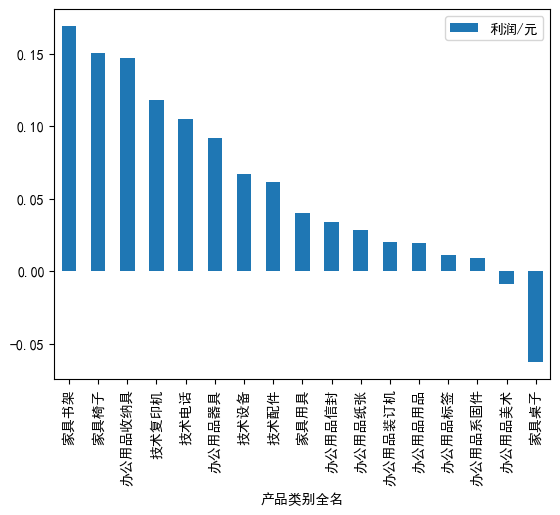

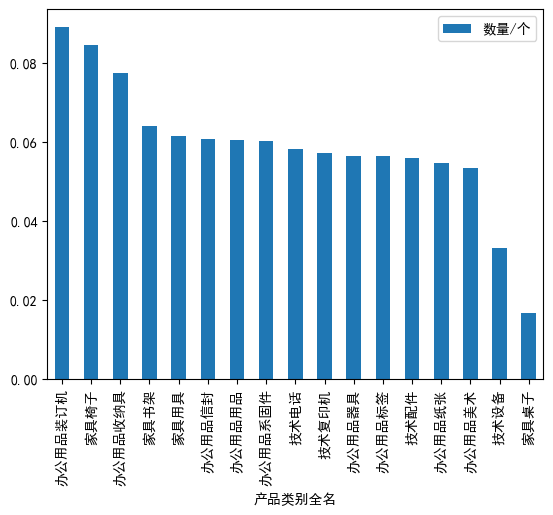

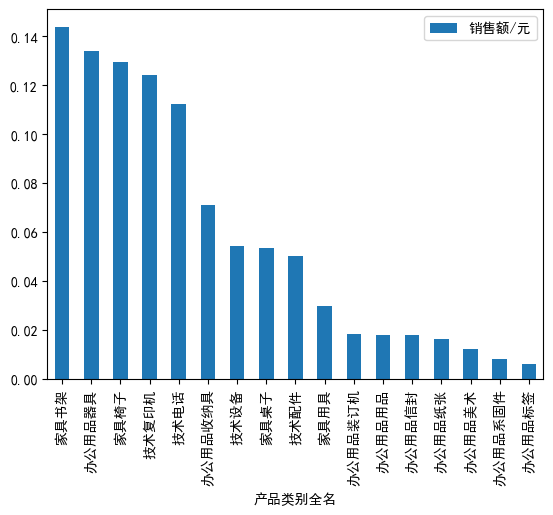

In [30]:
y1 = df_Category_Sub_Category['利润/元']/df_Category_Sub_Category['利润/元'].sum()
y2 = df_Category_Sub_Category['数量/个']/df_Category_Sub_Category['数量/个'].sum()
y3 = df_Category_Sub_Category['销售额/元']/df_Category_Sub_Category['销售额/元'].sum()
x1 = df_Category_Sub_Category.sort_values(by=['利润/元'],ascending=False)['产品类别全名']
x2 = df_Category_Sub_Category.sort_values(by=['数量/个'],ascending=False)['产品类别全名']
x3 = df_Category_Sub_Category.sort_values(by=['销售额/元'],ascending=False)['产品类别全名']
d1 = pd.core.frame.DataFrame([x1,y1]).T.set_index('产品类别全名')
d1[['利润/元']].plot(kind='bar')
d1 = pd.core.frame.DataFrame([x2,y2]).T.set_index('产品类别全名')
d1.plot(kind='bar')
d1 = pd.core.frame.DataFrame([x3,y3]).T.set_index('产品类别全名')
d1.plot(kind='bar')

### 6.3建立产品带

建立产品带，以检查是否对产品类别划分过于简略或者过于精细

In [31]:
# 同类别产品的最大差距
price_width = df[['产品类别全名','单价/元']].groupby(['产品类别全名']).max() - df[['产品类别全名','单价/元']].groupby(['产品类别全名']).min()
price_width.rename(columns={'单价/元':'width'},inplace=True)
# 同类别产品的不同价格数量
price_range = df[['产品类别全名','单价/元']].drop_duplicates()
price_range = price_range.groupby('产品类别全名').count()
price_range.rename(columns={'单价/元':'range'},inplace=True)
## 同类别产品的品牌数量
price_depth = df[['产品类别全名','产品 ID']].drop_duplicates()
price_depth = price_depth.groupby('产品类别全名').count()
price_depth.rename(columns={'产品 ID':'depth'},inplace=True)
price = pd.concat([price_width,price_range,price_depth],axis=1)
price

,width,range,depth
产品类别全名,,,
办公用品信封,211.680,163,117
办公用品器具,2561.300,243,116
办公用品收纳具,946.260,171,118
办公用品标签,44.380,137,118
办公用品用品,211.792,261,115
办公用品系固件,69.720,231,119
办公用品纸张,183.820,155,117
办公用品美术,256.060,300,115
办公用品装订机,236.124,279,119


# 7.从客户的角度分析

### 7.1检查客户流失率

7.1.1按照客户ID划分得到客户一次消费的数据

In [32]:
dff = df.copy()
dff.rename(columns={'订单日期':'Order_Date'},inplace=True)
grouped_Customer = dff[['客户 ID','Order_Date','销售额/元', '数量/个', '利润/元']].sort_values(['Order_Date']).groupby(['客户 ID'])
grouped_Customer.head()

,客户 ID,Order_Date,销售额/元,数量/个,利润/元
4213,21790,2022-01-01,427.140,3,16.800
9166,19900,2022-01-01,456.120,2,118.440
9167,19900,2022-01-01,591.500,5,194.600
1024,18505,2022-01-01,87.780,3,13.020
1252,10105,2022-01-02,751.660,7,112.700
...,...,...,...,...,...
4766,10300,2023-12-22,90.300,3,36.120
2674,14515,2023-12-25,7125.552,4,-2256.688
2673,14515,2023-12-25,3686.480,4,1732.640
8282,14650,2023-12-26,15504.048,8,5856.368


7.1.2选取客户第一次购买时间为初次登录时间，可以看出，23年新客户流入明显少于22年

<Axes: xlabel='Order_Date'>

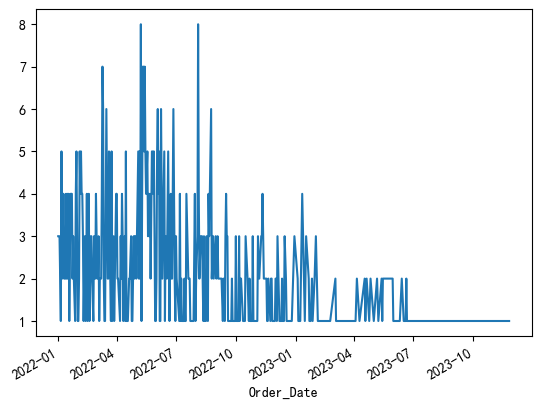

In [48]:
# 用户第一次购买日期
grouped_Customer.min().Order_Date.value_counts().sort_index().plot(kind='line')

7.1.3选取客户最后一次购买为最后登录时间，可以看出主要集中23年说明客户没有严重流失

<Axes: xlabel='Order_Date'>

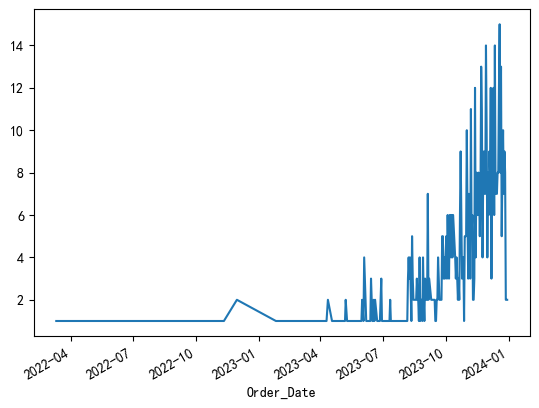

In [34]:
# 用户最后一次购买日期
grouped_Customer.max().Order_Date.value_counts().sort_index().plot(kind='line')

### 7.2统计客户的回购率，大多数客户都有多次购买的记录

In [35]:
# 统计每个客户第一次和最后一次购买记录
Customer_life = grouped_Customer.Order_Date.agg(['min','max'])
# 查看只有一次购买记录的顾客数量，第一次和最后一次是同一条记录，则说明购买只有一次
(Customer_life['min'] == Customer_life['max']).value_counts()

False    779
True      11
Name: count, dtype: int64

### 7.3RFM模型构建

7.3.1得到客户的消费金额（M），消费次数（F）和消费频率（R）

In [36]:
rfm = dff.pivot_table(index='客户 ID',
                    values = ["timecount","销售额/元","Order_Date"],
              aggfunc={"timecount":"sum","销售额/元":"sum","Order_Date":"max"})
 
# 所有用户最大的交易日期为标准，求每笔交易的时间间隔即为R
rfm['R'] = (rfm.Order_Date.max() - rfm.Order_Date)/np.timedelta64(1,'D')
# 每个客户的总销量即为F，总销售额即为M
rfm.rename(columns={"timecount":'F',"销售额/元":'M'},inplace = True)
rfm.head()

,Order_Date,F,M,R
客户 ID,,,,
10015,2023-11-25,17,9743.300,35.0
10030,2023-12-11,21,45494.848,19.0
10045,2023-12-15,19,15960.588,15.0
10060,2023-12-17,21,42256.802,13.0
10075,2023-12-12,20,26449.724,18.0


7.3.2利用二八法则，将客户价值划分为8个类别： （二八法则，20%的群体创造了80%的收益）,根据后面的计算，得到选取0.75作为分界线时，重要客户的销售额接近总销售额的一半

In [37]:
# 基于平均值做比较，超过均值为1，否则为0 
def rfm_func(x):
    level =x.apply(lambda x:'1'if x>=0 else '0')
    level =level.R +level.F +level.M
    d = {
        "111":"重要价值客户",
        "011":"重要保持客户",
        "101":"重要挽留客户",
        "001":"重要发展客户",
        "110":"一般价值客户",
        "010":"一般保持客户",
        "100":"一般挽留客户",
        "000":"一般发展客户"
    }
    result = d[level]
    return result
 
rfm['label']= rfm[['R','F','M']].apply(lambda x:x-x.quantile(0.75)).apply(rfm_func,axis =1)
rfm

,Order_Date,F,M,R,label
客户 ID,,,,,
10015,2023-11-25,17,9743.300,35.0,一般保持客户
10030,2023-12-11,21,45494.848,19.0,重要保持客户
10045,2023-12-15,19,15960.588,15.0,一般保持客户
10060,2023-12-17,21,42256.802,13.0,重要保持客户
10075,2023-12-12,20,26449.724,18.0,一般保持客户
...,...,...,...,...,...
21865,2023-11-10,6,8585.108,50.0,一般发展客户
21880,2023-12-19,20,25682.048,11.0,一般保持客户
21895,2023-10-01,12,11289.628,90.0,一般发展客户


7.3.3将重要价值客户作可视化展示

<Axes: xlabel='F', ylabel='R'>

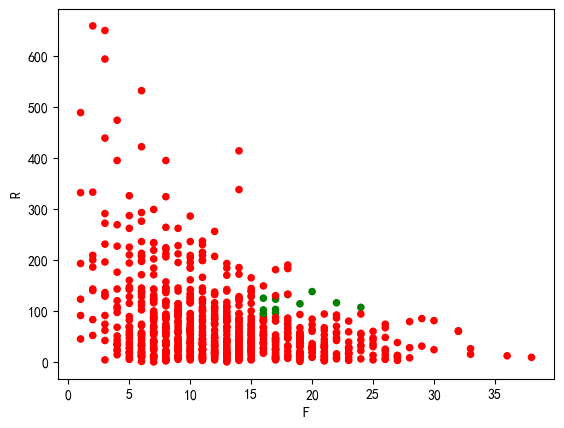

In [38]:
rfm.loc[rfm.label=='重要价值客户','color']='g'
rfm.loc[~(rfm.label=='重要价值客户'),'color']='r'
rfm.plot.scatter('F','R',c= rfm.color)

7.3.4查询重要客户的消费额占总的消费额的比例

In [39]:
rfm['vip'] = rfm['label'].apply(lambda x:1 if x.find('重要')!=-1 else 0)
vip = rfm[rfm['vip'] == 1].index
data_customer = dff[['利润/元','数量/个','销售额/元','客户 ID']].groupby('客户 ID').sum().reset_index()
data_customer['label'] = 0
data_customer['label'] = data_customer['客户 ID'].apply(lambda x:1 if x in vip  else 0)
xiao = data_customer[data_customer['label'] == 1]['销售额/元'].sum() / data_customer['销售额/元'].sum()
num = data_customer[data_customer['label'] == 1].count().sum() / data_customer.count().sum()
xiao

0.4875141861498266

### 7.4划分客户活跃度

7.4.1查询客户是否有在某月消费

In [40]:
pivoted_counts = dff.pivot_table(index= '客户 ID',
                               columns= '月',
                               values= 'Order_Date',
                               aggfunc= 'count').fillna(0)
# 大于一次的全部设为1
df_purchase = pivoted_counts.applymap(lambda x:1 if x>0 else 0)
df_purchase.head()

月,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
客户 ID,,,,,,,,,,,,,,,,,,,,,
10015,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
10030,0,0,0,1,0,0,0,0,1,1,...,1,0,1,0,0,1,1,1,0,1
10045,0,0,0,0,1,1,1,0,1,0,...,0,1,0,0,0,0,1,1,0,1
10060,0,0,1,0,1,1,1,1,0,0,...,0,1,0,1,0,0,0,1,0,1
10075,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,1,0,0,0,1


7.4.2对用户的活跃度进行划分

In [41]:
# 没有消费前记作未消费，消费的第一个月记作新用户，消费后之后的几个月没有再消费记作不活跃用户，
# 消费后隔了一段时间再来消费记作回归用户，消费后下一个月还再消费记作活跃用户
def active_status(data):
    status = []
    for i in range(24):
        if data[i] == 0:
            if len(status)>0:
                if status[i-1] == "unreg":
                 # 未注册客户
                    status.append("unreg")
                else:
                 # 不活跃用户
                    status.append("unactive")
            else:
                status.append("unreg")
            
        # 若本月消费了
        else:
            if len(status) == 0:
             # 新用户
                status.append("new")
            else:
                if status[i-1] == "unactive":
                 # 回归用户
                    status.append("return")
                elif status[i-1] == "unreg":
                    status.append("new")
                else:
                    status.append("active")
    return pd.Series(status)  
 
purchase_stats = df_purchase.apply(active_status,axis =1)
purchase_stats.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
客户 ID,,,,,,,,,,,,,,,,,,,,,
10015,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,unreg,...,active,unactive,unactive,unactive,return,unactive,return,unactive,return,unactive
10030,unreg,unreg,unreg,new,unactive,unactive,unactive,unactive,return,active,...,return,unactive,return,unactive,unactive,return,active,active,unactive,return
10045,unreg,unreg,unreg,unreg,new,active,active,unactive,return,unactive,...,unactive,return,unactive,unactive,unactive,unactive,return,active,unactive,return
10060,unreg,unreg,new,unactive,return,active,active,active,unactive,unactive,...,unactive,return,unactive,return,unactive,unactive,unactive,return,unactive,return
10075,unreg,unreg,unreg,unreg,unreg,unreg,new,active,unactive,unactive,...,return,unactive,unactive,unactive,return,active,unactive,unactive,unactive,return


7.4.3描绘每个月不同状态的用户的数量

<Axes: >

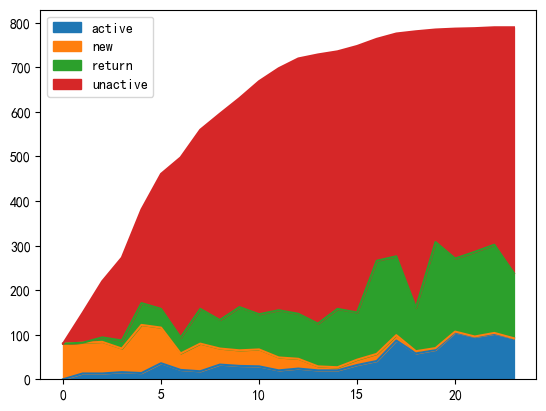

In [42]:
purchase_stats_ct = purchase_stats.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
# 用0填充NaN
purchase_stats_ct.fillna(0).T.plot.area()

### 7.4计算复购率，即在同一个月多次购买的人数占在同一个月有购买的人数的比例

0.5784789337265882

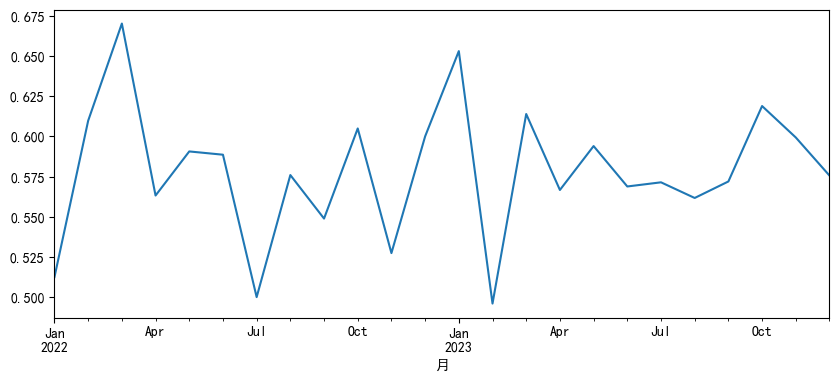

In [43]:
# 如果客户在一个月买了一次以上的记住1（有复购），如果只买过一次的记作0（没复购），连一次都没有的记作nan（没购买）
purchase_r = pivoted_counts.applymap(lambda x :1 if x>1 else np.NaN if x==0 else 0)
(purchase_r.sum()/purchase_r.count()).plot(figsize=(10,4))
(purchase_r.sum()/purchase_r.count()).mean()

### 7.5计算回购率，即连续几个月购买的客户对所有有购买行为的客户的占比

0.2245291125087279

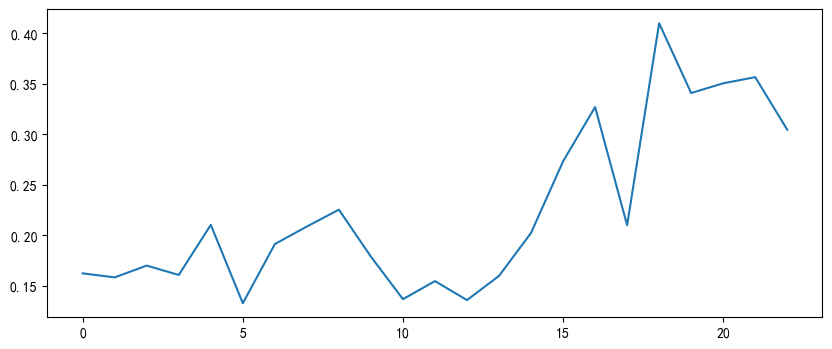

In [44]:
# 如果客户在这个月买了下个月也买了的记住1（有回购），如果这个月买了，下个月没买的记作0（没复购），该月没有购买行为的不计（没购买）
def purchase_back(data):
    status=[]
    for i in range(23):
        if data[i] ==1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    return status
 
purchase_b = df_purchase.apply(purchase_back,axis =1,result_type='expand')
(purchase_b.sum()/purchase_b.count()).plot(figsize=(10,4))
(purchase_b.sum()/purchase_b.count()).mean()

### 7.6按消费群体类型作划分

7.6.1查询各消费群体的情况

In [45]:
# 
growth_df = pd.pivot_table(df, index=['客户细分', '订货年'], values=['销售额/元'], aggfunc={'销售额/元': 'sum', '客户细分': 'count'})
growth_df = growth_df.rename(columns={'销售额/元': 'Sales_sum', '客户细分': 'Segment_count'})
growth_df = growth_df.reset_index()
growth_df.loc[(growth_df['订货年'] == 2022),['销售占比']] = growth_df[growth_df['订货年'] == 2022]['Sales_sum'] / growth_df[growth_df['订货年'] == 2022]['Sales_sum'].sum()
growth_df.loc[(growth_df['订货年'] == 2023),['销售占比']] = growth_df[growth_df['订货年'] == 2023]['Sales_sum'] / growth_df[growth_df['订货年'] == 2023]['Sales_sum'].sum()
growth_df.loc[(growth_df['订货年'] == 2022),['次数占比']] = growth_df[growth_df['订货年'] == 2022]['Segment_count'] / growth_df[growth_df['订货年'] == 2022]['Segment_count'].sum()
growth_df.loc[(growth_df['订货年'] == 2023),['次数占比']] = growth_df[growth_df['订货年'] == 2023]['Segment_count'] / growth_df[growth_df['订货年'] == 2023]['Segment_count'].sum()
growth_df

,客户细分,订货年,Segment_count,Sales_sum,销售占比,次数占比
0,公司,2022,1041,1777160.595,0.325350,0.308353
1,公司,2023,2017,3331570.697,0.317264,0.310930
2,小型企业,2022,579,947091.271,0.173387,0.171505
3,小型企业,2023,1170,1925990.934,0.183411,0.180361
4,消费者,2022,1756,2738056.825,0.501264,0.520142
5,消费者,2023,3300,5243394.219,0.499325,0.508710


7.6.2得到每个消费群体人数的比例，求得其与销售额和购买次数的比例相近

In [46]:
# 
data_segment = dff[['客户 ID','timecount','客户细分']].groupby(['客户细分','客户 ID']).mean()
data_segment = data_segment.reset_index()
num = []
num.append(data_segment[data_segment['客户细分'] == '公司']['timecount'].sum() / data_segment['timecount'].sum())
num.append(data_segment[data_segment['客户细分'] == '小型企业']['timecount'].sum() / data_segment['timecount'].sum())
num.append(data_segment[data_segment['客户细分'] == '消费者']['timecount'].sum() / data_segment['timecount'].sum()) 
num

[0.3012658227848101, 0.18227848101265823, 0.5164556962025316]

### 7.7查询不同地区的客户是否存在类型分布不同

In [47]:
xiao_preference = pd.pivot_table(df,index=['地区'],columns=['地区'],aggfunc={'地区':'count'} )
xiao_preference = xiao_preference['地区'] / xiao_preference['地区'].sum()
xiao_preference = xiao_preference.fillna(0)
xiao_preference.style.background_gradient()
xiao_preference = pd.pivot_table(df,index=['客户细分'],columns=['地区'],aggfunc={'地区':'count'} )
xiao_preference = xiao_preference['地区'] / xiao_preference['地区'].sum()
xiao_preference = xiao_preference.fillna(0)
xiao_preference.style.background_gradient()

地区,东北,华东,华中,华北,华南,西北,西南
客户细分,,,,,,,
公司,0.309047,0.300827,0.344780,0.294505,0.289737,0.318658,0.328962
小型企业,0.182149,0.189524,0.161401,0.193407,0.190736,0.125786,0.142077
消费者,0.508804,0.509649,0.493819,0.512088,0.519528,0.555556,0.528962


,订单 ID,订单日期,发货日期,客户 ID,客户细分,城市,省/自治区,地区,产品 ID,产品类别,...,发货月,订货年,订货月,发货用时,单价/元,月,timecount,产品类别全名,discount,if_discount
0,CN-2022-1973789,2022-06-15,2022-06-19,10165,消费者,内江,四川,西南,办公用-信封-10004832,办公用品,...,6,2022,6,4,62.720,2022-06-01,1,办公用品信封,0.7,1
1,CN-2022-1973789,2022-06-15,2022-06-19,10165,消费者,内江,四川,西南,办公用-装订-10001505,办公用品,...,6,2022,6,4,15.960,2022-06-01,1,办公用品装订机,0.6,1
2,US-2022-3017568,2022-12-09,2022-12-13,17170,公司,镇江,江苏,华东,办公用-用品-10003746,办公用品,...,12,2022,12,4,80.304,2022-12-01,1,办公用品用品,0.6,1
3,CN-2023-2975416,2023-05-31,2023-06-02,15730,消费者,汕头,广东,华南,办公用-器具-10003452,办公用品,...,6,2023,5,2,458.640,2023-05-01,1,办公用品器具,1.0,0
4,CN-2023-4497736,2023-10-27,2023-10-31,18325,消费者,景德镇,江西,华东,技术-设备-10001640,技术,...,10,2023,10,4,1236.620,2023-10-01,1,技术设备,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9858,CN-2022-4318875,2022-05-28,2022-06-02,13435,消费者,义乌,浙江,华东,技术-配件-10003923,技术,...,6,2022,5,5,314.748,2022-05-01,1,技术配件,0.6,1
9859,CN-2022-4318875,2022-05-28,2022-06-02,13435,消费者,义乌,浙江,华东,办公用-收纳-10003383,办公用品,...,6,2022,5,5,223.860,2022-05-01,1,办公用品收纳具,1.0,0
9860,CN-2022-4318875,2022-05-28,2022-06-02,13435,消费者,义乌,浙江,华东,家具-椅子-10002448,家具,...,6,2022,5,5,239.988,2022-05-01,1,家具椅子,0.6,1
9861,CN-2022-4318875,2022-05-28,2022-06-02,13435,消费者,义乌,浙江,华东,技术-配件-10002808,技术,...,6,2022,5,5,693.084,2022-05-01,1,技术配件,0.6,1
